### In this notebook, we analyze whether using big drops (calculated in a gradient-based fashion) in the gains brought by candidate features might help us determine classes "gain" and "loss" in a way that is more meaningul.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import median_absolute_deviation
import math
import warnings; warnings.simplefilter('ignore')

### Let's start by analyzing the initial gain for the college dataset.

In [2]:
def train_and_test_model(data, target_variable_name):
    """Builds a model using data to predict the target variable.
    """

    X_train, X_test, y_train, y_test = train_test_split(
        data.drop(target_variable_name, axis=1),
        data[target_variable_name],
        test_size=0.33,
        random_state=42
    )

    # normalizing data first
    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train.values.reshape(-1, 1))
    X_train = scaler_X.transform(X_train)
    y_train = scaler_y.transform(y_train.values.reshape(-1, 1))
    X_test = scaler_X.transform(X_test)
    y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

    forest = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=len(data.columns)-1
    )
    forest.fit(X_train, y_train.ravel())
    yfit = forest.predict(X_test)

    return r2_score(y_test, yfit)

In [3]:
def get_performance_scores(data, target_variable_name, missing_value_imputation):
    """Builds a model using data to predict the target variable,
    returning different performance metrics.
    """

    if missing_value_imputation:
        
        # imputation on data
        fill_NaN = SimpleImputer(missing_values=np.nan, strategy='mean')
        new_data = pd.DataFrame(fill_NaN.fit_transform(data))
        new_data.columns = data.columns
        new_data.index = data.index

        # training and testing model
        return train_and_test_model(new_data, target_variable_name)

    else:
        return train_and_test_model(data, target_variable_name)

In [4]:
college_debt = pd.read_csv('data/college-debt-v2.csv')
college_debt.index = college_debt['UNITID']
college_debt.drop(['UNITID'], axis=1, inplace=True)
college_debt.head()

,PCTFLOAN,PCIP16,PPTUG_EF,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,SATMTMID,SATVRMID,SATWRMID,UGDS,DEBT_EARNINGS_RATIO
UNITID,,,,,,,,,,,,
12268508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49
207564,0.4750,0.0000,0.2297,0.2953,0.0291,0.0647,0.0051,NaN,NaN,NaN,2164.0,36
420024,0.8125,0.0000,0.2315,0.2808,0.5665,0.0493,0.0000,NaN,NaN,NaN,203.0,127
164492,0.7465,0.0000,0.2621,0.6518,0.1258,0.1022,0.0123,NaN,NaN,NaN,1057.0,76
234085,0.4589,0.0321,0.0000,0.7992,0.0607,0.0584,0.0420,575.0,575.0,NaN,1713.0,53


In [5]:
scores_query = get_performance_scores(
    college_debt,
    'DEBT_EARNINGS_RATIO',
    True
)
scores_query

0.39565581099809455

### Now, let's see the gains that we get for all of its candidates

In [6]:
college_candidate_gains = pd.read_csv('../classification/college-debt-records-features-single-column-w-class')
college_candidate_gains.head()

,query,target,candidate,query_num_of_columns,query_num_of_rows,query_row_column_ratio,query_max_mean,query_max_outlier_percentage,query_max_skewness,query_max_kurtosis,...,decrease_in_mae,decrease_in_mse,decrease_in_medae,gain_in_r2_score,r2_score_before,r2_score_after,class,p(gain),p(loss),eval
0,/Users/fchirigati/projects/dataset-ranking/use...,DEBT_EARNINGS_RATIO,/Users/fchirigati/projects/dataset-ranking/use...,12.0,4990.0,415.833333,3141.540889,0.009218,5.838487,50.966273,...,0.012156,-0.018932,-0.013892,-0.095708,0.395656,0.357789,loss,0.73,0.27,fp
1,/Users/fchirigati/projects/dataset-ranking/use...,DEBT_EARNINGS_RATIO,/Users/fchirigati/projects/dataset-ranking/use...,12.0,4990.0,415.833333,3141.540889,0.009218,5.838487,50.966273,...,0.012156,-0.018932,-0.013892,-0.095708,0.395656,0.357789,loss,0.68,0.32,fp
2,/Users/fchirigati/projects/dataset-ranking/use...,DEBT_EARNINGS_RATIO,/Users/fchirigati/projects/dataset-ranking/use...,12.0,4990.0,415.833333,3141.540889,0.009218,5.838487,50.966273,...,0.012156,-0.018932,-0.013892,-0.095708,0.395656,0.357789,loss,0.69,0.31,fp
3,/Users/fchirigati/projects/dataset-ranking/use...,DEBT_EARNINGS_RATIO,/Users/fchirigati/projects/dataset-ranking/use...,12.0,4990.0,415.833333,3141.540889,0.009218,5.838487,50.966273,...,0.012156,-0.018932,-0.013892,-0.095708,0.395656,0.357789,loss,0.69,0.31,fp
4,/Users/fchirigati/projects/dataset-ranking/use...,DEBT_EARNINGS_RATIO,/Users/fchirigati/projects/dataset-ranking/use...,12.0,4990.0,415.833333,3141.540889,0.009218,5.838487,50.966273,...,0.012156,-0.018932,-0.013892,-0.095708,0.395656,0.357789,loss,0.69,0.31,fp


### Let's check the gain distribution

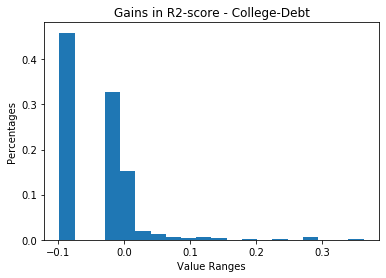

In [7]:
OUTLIER_THRESHOLD_MAD = 2

def remove_outliers_based_on_mad(data):
    mad = median_absolute_deviation(data)
    median = np.median(data)
    return [i for i in data if np.fabs((i - median)/mad) < OUTLIER_THRESHOLD_MAD]

def plot_histogram(case_study, gains, remove_outliers_mad=False):
    if remove_outliers_mad:
        gains = remove_outliers_based_on_mad(gains)

    weights = np.ones_like(gains)/float(len(gains))
    plt.hist(gains, bins=20, weights=weights)
    plt.xlabel('Value Ranges')
    plt.ylabel('Percentages')
    plt.title('Gains in R2-score - ' + case_study)
    plt.show()

gains = college_candidate_gains['gain_in_r2_score']
plot_histogram('College-Debt', gains)

### Let's compute the gradients to see when the gains start dropping.

In [21]:
def compute_gradients(candidate_gains):
    '''
    given a table with features 'candidate' and 'gain_in_r2_score', 
    this method creates a list with these two fields, sorts it in ascending order of gains 
    and computes the gradients between elements in positions x and x - 1
    '''
    gains = sorted([[row['query'], row['candidate'], row['gain_in_r2_score']] 
                    for index, row in candidate_gains.iterrows()], 
                   key=lambda x: x[2])
    gradients = [float('-inf')]
    for index, elem in enumerate(gains):
        if index < len(gains) - 1:
            gradients.append(gains[index + 1][2] - gains[index][2])
            
    gains_gradients = []
    for gain, gradient in zip(gains, gradients):
        gain.append(gradient)
        gains_gradients.append(gain)
        
    return gains_gradients

college_gains_gradients = compute_gradients(college_candidate_gains)
college_gains_gradients[-10:]

[['/Users/fchirigati/projects/dataset-ranking/use-cases/data/college-debt/college-debt-v2.csv',
  '/Users/fchirigati/projects/dataset-ranking/use-cases/datamart-data/companion-datasets-single-column/datamart.upload.a817349748524c618bec5505f46feaef_UNITID_RET_FTL4',
  0.19484267796557944,
  0.0],
 ['/Users/fchirigati/projects/dataset-ranking/use-cases/data/college-debt/college-debt-v2.csv',
  '/Users/fchirigati/projects/dataset-ranking/use-cases/datamart-data/companion-datasets-single-column/datamart.socrata.data-wa-gov.wajg-ig9g_UNITID_OPEID6',
  0.2443284449850829,
  0.04948576701950347],
 ['/Users/fchirigati/projects/dataset-ranking/use-cases/data/college-debt/college-debt-v2.csv',
  '/Users/fchirigati/projects/dataset-ranking/use-cases/datamart-data/companion-datasets-single-column/datamart.upload.a817349748524c618bec5505f46feaef_UNITID_OPEID6',
  0.2443284449850829,
  0.0],
 ['/Users/fchirigati/projects/dataset-ranking/use-cases/data/college-debt/college-debt-v2.csv',
  '/Users/fch

### It looks like the biggest drop is between the top-rated candidate and the second one. Is it safe to assume that we only have one really good candidate? Maybe we can implement a few different policies...

In [22]:
def harsh_gradient_policy(candidates_gains_gradients):
    '''
    Given a list of candidates such that each entry corresponds to 
    
        ['query', candidate', 'gain', 'gradient']
    
    and the list is sorted (ascending order) based on 'gain',
    this method finds the position that corresponds to the largest gradient, 
    and then sets the class of every candidate equals to or below it position-wise to 'loss'. 
    The other candidates are linked to label 'gain' unless their 'gain' values are negative.
    '''
    
    # Can't use Python's "index" function because it gets the first occurrence of a value. If 
    # the maximum gradient occurs more than once, we're interested in its last occurrence.
    max_gradient = float('-inf')
    position = -1
    for index, elem in enumerate(reversed(candidates_gains_gradients)):
        if elem[3] >= max_gradient:
            max_gradient = elem[3]
        else: # drop in gradient
            position = len(candidates_gains_gradients) - index -1
            break
    
    labels = [(elem[0], elem[1], 'gain') if index > position and elem[2] > 0 else (elem[0], elem[1], 'loss') 
              for index, elem in enumerate(candidates_gains_gradients)]
     
    return pd.DataFrame(labels, columns = ['query', 'candidate', 'harsh_grad_class'])

def nth_gradient_drop_policy(candidates_gains_gradients, n):
    '''
    Given a list of candidates such that each entry corresponds to 
    
        ['query', candidate', 'gain', 'gradient']
    
    and the list is sorted (ascending order) based on 'gain', 
    and an integer n, this method finds the position that corresponds 
    to the n-th gradient drop. Next, it sets the class of every candidate 
    equals to or below it (position-wise) to 'loss'. The other candidates are 
    linked to label 'gain'.
    '''
    
    max_gradient = float('-inf')
    position = -1
    drops_seen = 0
    for index, elem in enumerate(reversed(candidates_gains_gradients)):
        if elem[3] >= max_gradient:
            max_gradient = elem[3]
        else: # drop in gradient
            drops_seen += 1
            position = len(candidates_gains_gradients) - index -1
            if drops_seen == n:
                break
            else:
                max_gradient = elem[3] #refactor this repetition
   
    labels = [(elem[0], elem[1], 'gain') if index > position and elem[2] > 0 else (elem[0], elem[1], 'loss') 
              for index, elem in enumerate(candidates_gains_gradients)]
     
    return pd.DataFrame(labels, columns = ['query', 'candidate', str(n) + 'th_grad_drop_class'])

def get_order_of_magnitude(value):
    '''
    Returns order of magnitude of a given value
    '''
    if not value:
        return float('-inf')
    try:
        return math.floor(math.log(np.fabs(value), 10))
    except ValueError:
        print('*** ERRRRRROOOOOORRR', value)
        return None

def order_of_magnitude_drop_policy(candidates_gains_gradients):
    '''
    Given a list of candidates such that each entry corresponds to 
    
        ['query', candidate', 'gain', 'gradient']
    
    and the list is sorted (ascending order) based on 'gain', this method 
    finds the position that corresponds to the first drop in an order of 
    magnitude and sets the class of every candidate equals to or below it 
    (position-wise) to 'loss'. The other candidates are linked to label 'gain'.
    '''
    highest_order_of_magnitude = get_order_of_magnitude(candidates_gains_gradients[-1][2])
    position = -1
    for index, elem in enumerate(reversed(candidates_gains_gradients)):
        if get_order_of_magnitude(elem[2]) < highest_order_of_magnitude:
            position = len(candidates_gains_gradients) - index -1
            break

    labels = [(elem[0], elem[1], 'gain') if index > position and elem[2] > 0 else (elem[0], elem[1], 'loss') 
              for index, elem in enumerate(candidates_gains_gradients)]
     
    return pd.DataFrame(labels, columns = ['query', 'candidate', 'order_of_mag_drop_class'])

def median_based_policy(candidates_gains_gradients):
    '''
    Given a list of candidates such that each entry corresponds to 
    
        ['query', candidate', 'gain', 'gradient']
    
    and the list is sorted (ascending order) based on 'gain', this method 
    gets the median position and sets the class of every candidate equals to or below it 
    (position-wise) to 'loss'. The other candidates are linked to label 'gain'.
    '''
    position = math.ceil(len(candidates_gains_gradients)/2)
    labels = [(elem[0], elem[1], 'gain') if index > position and elem[2] > 0 else (elem[0], elem[1], 'loss') 
              for index, elem in enumerate(candidates_gains_gradients)]
     
    return pd.DataFrame(labels, columns = ['query', 'candidate', 'median_based_class'])    

### Now, let's create class labels for datasets based on these different policies

In [23]:
# The original column 'class' in the dataset is such that if 'gain_in_r2_score' > 0, 
# the label is 'gain'; otherwise, it is 'loss'.
college_candidate_gains = college_candidate_gains.rename(columns={'class': 'class_pos_neg'})
harsh_gradient_classes = harsh_gradient_policy(college_gains_gradients)
second_grad_drop_classes = nth_gradient_drop_policy(college_gains_gradients, 2)
order_of_magnitude_drop_classes = order_of_magnitude_drop_policy(college_gains_gradients)
median_based_classes = median_based_policy(college_gains_gradients)

college_candidate_gains = college_candidate_gains.merge(harsh_gradient_classes, on=['query', 'candidate']) 
college_candidate_gains = college_candidate_gains.merge(second_grad_drop_classes, on=['query', 'candidate'])
college_candidate_gains = college_candidate_gains.merge(order_of_magnitude_drop_classes, on=['query', 'candidate'])
college_candidate_gains = college_candidate_gains.merge(median_based_classes, on=['query', 'candidate'])

In [24]:
college_candidate_gains.shape

(1103, 47)

### Let's do the same for taxi, poverty, and openml-based datasets that were created for training.

In [26]:
taxi_candidate_gains = pd.read_csv('../classification/taxi-vehicle-collision-records-features-single-column-w-class')
taxi_gains_gradients = compute_gradients(taxi_candidate_gains)
print('before', taxi_candidate_gains.shape)

taxi_candidate_gains = taxi_candidate_gains.rename(columns={'class': 'class_pos_neg'})
harsh_gradient_classes = harsh_gradient_policy(taxi_gains_gradients)
second_grad_drop_classes = nth_gradient_drop_policy(taxi_gains_gradients, 2)
order_of_magnitude_drop_classes = order_of_magnitude_drop_policy(taxi_gains_gradients)
median_based_classes = median_based_policy(taxi_gains_gradients)

taxi_candidate_gains = taxi_candidate_gains.merge(harsh_gradient_classes, on=['query', 'candidate']) 
taxi_candidate_gains = taxi_candidate_gains.merge(second_grad_drop_classes, on=['query', 'candidate'])
taxi_candidate_gains = taxi_candidate_gains.merge(order_of_magnitude_drop_classes, on=['query', 'candidate'])
taxi_candidate_gains = taxi_candidate_gains.merge(median_based_classes, on=['query', 'candidate'])
print('after', taxi_candidate_gains.shape)

before (447, 39)
after (447, 43)


In [36]:
poverty_candidate_gains = pd.read_csv('../classification/poverty-estimation-results-features-and-targets-training.csv')
poverty_candidate_gains.drop_duplicates(subset=['query', 'candidate'])
poverty_gains_gradients = compute_gradients(poverty_candidate_gains)
print('before', poverty_candidate_gains.shape)

poverty_candidate_gains = poverty_candidate_gains.rename(columns={'class': 'class_pos_neg'})
harsh_gradient_classes = harsh_gradient_policy(poverty_gains_gradients).drop_duplicates(subset=['query', 'candidate'])
second_grad_drop_classes = nth_gradient_drop_policy(poverty_gains_gradients, 2).drop_duplicates(subset=['query', 'candidate'])
order_of_magnitude_drop_classes = order_of_magnitude_drop_policy(poverty_gains_gradients).drop_duplicates(subset=['query', 'candidate'])
median_based_classes = median_based_policy(poverty_gains_gradients).drop_duplicates(subset=['query', 'candidate'])

poverty_candidate_gains = poverty_candidate_gains.merge(harsh_gradient_classes, on=['query', 'candidate'], how='left') 
poverty_candidate_gains = poverty_candidate_gains.merge(second_grad_drop_classes, on=['query', 'candidate'], how='left')
poverty_candidate_gains = poverty_candidate_gains.merge(order_of_magnitude_drop_classes, on=['query', 'candidate'], how='left')
poverty_candidate_gains = poverty_candidate_gains.merge(median_based_classes, on=['query', 'candidate'], how='left')
print('after', poverty_candidate_gains.shape)

before (130928, 37)
after (130928, 41)


### Now, regarding the openml-based datasets, we need to separate query by query and treat each one of them as a subproblem.

In [40]:
openml_training_candidate_gains = pd.read_csv('../classification/training-simplified-data-generation-many-candidates-per-query_with_median_and_mean_based_classes.csv')
openml_training_candidate_gains['class_pos_neg'] = ['loss' if row['gain_in_r2_score'] <= 0 else 'gain' 
                                                    for index, row in openml_training_candidate_gains.iterrows()]
openml_training_candidate_gains = openml_training_candidate_gains.drop_duplicates(subset=['query', 'candidate'])

harsh_gradient_classes = []
second_grad_drop_classes = []
order_of_magnitude_drop_classes = []
median_based_classes = []

queries = set(openml_training_candidate_gains['query'])
number_of_queries = len(queries); i = 0
print('*** NUMBER OF QUERIES', number_of_queries)
for q in queries:
    subtable = openml_training_candidate_gains.loc[openml_training_candidate_gains['query'] == q]
    sub_gains_gradients = compute_gradients(subtable)    
    
    sub_harsh_gradient_classes = harsh_gradient_policy(sub_gains_gradients)
    harsh_gradient_classes.append(sub_harsh_gradient_classes)
    
    sub_second_grad_drop_classes = nth_gradient_drop_policy(sub_gains_gradients, 2)
    second_grad_drop_classes.append(sub_second_grad_drop_classes)
    
    sub_order_of_magnitude_drop_classes = order_of_magnitude_drop_policy(sub_gains_gradients)
    order_of_magnitude_drop_classes.append(sub_order_of_magnitude_drop_classes)
    
    sub_median_based_classes = median_based_policy(sub_gains_gradients)
    median_based_classes.append(sub_median_based_classes)
    i += 1
    if i % 1000 == 0:
        print(i)

harsh_gradient_classes = pd.concat(harsh_gradient_classes).drop_duplicates(subset=['query', 'candidate'])
second_grad_drop_classes = pd.concat(second_grad_drop_classes).drop_duplicates(subset=['query', 'candidate'])
order_of_magnitude_drop_classes = pd.concat(order_of_magnitude_drop_classes).drop_duplicates(subset=['query', 'candidate'])
median_based_classes = pd.concat(median_based_classes).drop_duplicates(subset=['query', 'candidate'])

*** NUMBER OF QUERIES 5138
1000
2000
3000
4000
5000


In [41]:
f = open('openml_training_many_candidates_harsh_grad_classes.csv', 'w')
f.write(harsh_gradient_classes.to_csv(index=False))
f.close()

f = open('openml_training_many_candidates_second_grad_drop_classes.csv', 'w')
f.write(second_grad_drop_classes.to_csv(index=False))
f.close()

f = open('openml_training_many_candidates_order_magnitude_drop_classes.csv', 'w')
f.write(order_of_magnitude_drop_classes.to_csv(index=False))
f.close()

f = open('openml_training_many_candidates_median_based_classes.csv', 'w')
f.write(median_based_classes.to_csv(index=False))
f.close()



In [42]:
print(harsh_gradient_classes.shape, 
      second_grad_drop_classes.shape, 
      order_of_magnitude_drop_classes.shape,
      median_based_classes.shape,
      openml_training_candidate_gains.shape
     )

print('before', openml_training_candidate_gains.shape)
openml_training_candidate_gains = openml_training_candidate_gains.merge(harsh_gradient_classes, on=['query', 'candidate'], how='left') 
openml_training_candidate_gains = openml_training_candidate_gains.merge(second_grad_drop_classes, on=['query', 'candidate'], how='left')
openml_training_candidate_gains = openml_training_candidate_gains.merge(order_of_magnitude_drop_classes, on=['query', 'candidate'], how='left')
openml_training_candidate_gains = openml_training_candidate_gains.merge(median_based_classes, on=['query', 'candidate'], how='left')
print('after', openml_training_candidate_gains.shape)
#openml_training_candidate_gains.head()

(529214, 3) (529214, 3) (529214, 3) (529214, 3) (529214, 39)
before (529214, 39)
after (529214, 43)


### Now let's do it for the openml test data

In [43]:
openml_test_candidate_gains = pd.read_csv('../classification/test-simplified-data-generation-many-candidates-per-query_with_median_and_mean_based_classes.csv')
openml_test_candidate_gains['class_pos_neg'] = ['loss' if row['gain_in_r2_score'] <= 0 else 'gain' 
                                                    for index, row in openml_test_candidate_gains.iterrows()]
openml_test_candidate_gains = openml_test_candidate_gains.drop_duplicates(subset=['query', 'candidate'])

harsh_gradient_classes = []
second_grad_drop_classes = []
order_of_magnitude_drop_classes = []
median_based_classes = []

queries = set(openml_test_candidate_gains['query'])
number_of_queries = len(queries); i = 0
print('*** NUMBER OF QUERIES', number_of_queries)
for q in queries:
    subtable = openml_test_candidate_gains.loc[openml_test_candidate_gains['query'] == q]
    sub_gains_gradients = compute_gradients(subtable)    
    
    sub_harsh_gradient_classes = harsh_gradient_policy(sub_gains_gradients)
    harsh_gradient_classes.append(sub_harsh_gradient_classes)
    
    sub_second_grad_drop_classes = nth_gradient_drop_policy(sub_gains_gradients, 2)
    second_grad_drop_classes.append(sub_second_grad_drop_classes)
    
    sub_order_of_magnitude_drop_classes = order_of_magnitude_drop_policy(sub_gains_gradients)
    order_of_magnitude_drop_classes.append(sub_order_of_magnitude_drop_classes)
    
    sub_median_based_classes = median_based_policy(sub_gains_gradients)
    median_based_classes.append(sub_median_based_classes)
    i += 1
    if i % 1000 == 0:
        print(i)

harsh_gradient_classes = pd.concat(harsh_gradient_classes).drop_duplicates(subset=['query', 'candidate'])
second_grad_drop_classes = pd.concat(second_grad_drop_classes).drop_duplicates(subset=['query', 'candidate'])
order_of_magnitude_drop_classes = pd.concat(order_of_magnitude_drop_classes).drop_duplicates(subset=['query', 'candidate'])
median_based_classes = pd.concat(median_based_classes).drop_duplicates(subset=['query', 'candidate'])

*** NUMBER OF QUERIES 1942
1000


In [44]:
print(harsh_gradient_classes.shape, 
      second_grad_drop_classes.shape, 
      order_of_magnitude_drop_classes.shape,
      median_based_classes.shape,
      openml_test_candidate_gains.shape
     )

print('before', openml_test_candidate_gains.shape)
openml_test_candidate_gains = openml_test_candidate_gains.merge(harsh_gradient_classes, on=['query', 'candidate'], how='left') 
openml_test_candidate_gains = openml_test_candidate_gains.merge(second_grad_drop_classes, on=['query', 'candidate'], how='left')
openml_test_candidate_gains = openml_test_candidate_gains.merge(order_of_magnitude_drop_classes, on=['query', 'candidate'], how='left')
openml_test_candidate_gains = openml_test_candidate_gains.merge(median_based_classes, on=['query', 'candidate'], how='left')
print('after', openml_test_candidate_gains.shape)
#openml_training_candidate_gains.head()

(75738, 3) (75738, 3) (75738, 3) (75738, 3) (75738, 39)
before (75738, 39)
after (75738, 43)


### Let's save all these new versions of the datasets on disk now.

In [45]:
f = open('../classification/college-debt-different-class-definitions.csv', 'w')
f.write(college_candidate_gains.to_csv(index=False))
f.close()

f = open('../classification/taxi-vehicle-collision-different-class-definitions.csv', 'w')
f.write(taxi_candidate_gains.to_csv(index=False))
f.close()

f = open('../classification/poverty-estimation-different-class-definitions.csv', 'w')
f.write(poverty_candidate_gains.to_csv(index=False))
f.close()

f = open('../classification/training-simplified-data-generation-many-candidates-different-class-definitions.csv', 'w')
f.write(openml_training_candidate_gains.to_csv(index=False))
f.close()

f = open('../classification/test-simplified-data-generation-many-candidates-different-class-definitions.csv', 'w')
f.write(openml_test_candidate_gains.to_csv(index=False))
f.close()